## Call Imports

In [40]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy as scip
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.nn import functional as F
import matplotlib.patches as patches

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


In [41]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 2.759 GB: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

Deduplicating...


Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



## Run Single Tile intervention

In [131]:
# Because of the new board representation, we should not use KLi's previous intervention function
def intervene_general(p, init_act, target_board, htd, rand_start=False):
    if rand_start:
        new_mid_act = torch.tensor(torch.rand(init_act.shape), dtype=torch.float32).to(device)
        new_mid_act.requires_grad=True
    else:
        new_mid_act = torch.tensor(init_act.clone().detach().cpu().numpy(), dtype=torch.float32).to(device)
        new_mid_act.requires_grad = True

    opt = torch.optim.Adam([new_mid_act], lr=htd["lr"])
    target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
    target_board.requires_grad=False
    for i in range(htd["steps"]):
        opt.zero_grad()
        logits_running = p(new_mid_act[None, :])[0][0]  # [64, 3]
        loss = F.cross_entropy(logits_running, target_board)        
        loss = torch.mean(loss)
        loss.backward()  # by torch semantics, loss is to be minimized
        opt.step()

    return new_mid_act

def run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=False, verbose=False, property="New"):
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    x = x.to(device)
    ab = OthelloBoardState()
    ab.update(tbf[:number_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)

    # fig = plt.figure()
    # ax = plt_utils.addAxis(fig,1,4)
    # plt_utils.plot_game_discs(init_board, ax[0])

    idx_of_interest = number_moves-1 # This corresponds to the index for the next game-move
    padding = torch.zeros(2) if device=="cpu" else torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them

    # Load the GPT Model for gameplay 
    n_layer = int(probe_path[-5:-4])
    n_head = int(probe_path[-3:-2])
    gpt_othello_ckpt = probe_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose: 
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load(gpt_othello_ckpt))
    model.eval()
    model = model.to(device) 
    
    # Load the set of probes
    probe_set = []
    for layer in range(1,n_layer+1):
        probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
        probe_ckpt = probe_path + f"linearProbe_Map_{property}_{n_layer}L{n_head}H_GPT_Layer{layer}.ckpt"
        if verbose:
            print(f"Loading Pre-trained probe for layer: {layer}", probe_ckpt)
        probe.load_state_dict(torch.load(probe_ckpt))
        probe.eval()
        probe_set.append(probe)
    
    # Compute the logits with no intervention
    intv_activation = model.forward_1st_stage(-1, x[None, :])[0]
    init_pred, _ = model.predict(intv_activation)
    init_pred = init_pred[idx_of_interest, 1:]
    init_pred = torch.cat([init_pred[:27], padding, init_pred[27:33], padding, init_pred[33:]], dim=0)
    init_pred = init_pred.detach().cpu().reshape(8,8).numpy()

    # Compute the intervention and the new predictions
    htd = {"lr": 1e-2, "steps": 1000, "reg_strg": 0.2}
    interv_boards = []
    interv_preds = []
    actions=[]
    for square in intervention_moves:
        tile_number = permit(square)
        r, c = tile_number // 8, tile_number % 8    
        if init_board[r,c]==1.0:
            action = f"Pos: {square} No change"
            interv_boards.append(None)
            interv_preds.append(None)
            continue
        else:
            action = f"Pos: {square} State flipped"
        actions.append(action)

        if verbose: 
            print(action)
            
        # Get the layer activation and use probe to get the board state
        intv_activation = model.forward_1st_stage(probe_layer, x[None, :])[0]
        board, _ = probe_set[probe_layer-1](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        targ_board = board[idx_of_interest,:].clone()
        targ_board[tile_number] = 2.0 - targ_board[tile_number]
        post_intv_activation = intervene_general(probe_set[probe_layer-1], intv_activation[idx_of_interest,:], targ_board, htd)

        # plt_utils.plot_game_discs(board[idx_of_interest, :].reshape(8,8), ax[1])
        # plt_utils.plot_game_discs(targ_board[:].reshape(8,8), ax[2])

        # Update activation
        intv_activation[idx_of_interest, :] = post_intv_activation
        board, _ = probe_set[probe_layer-1](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        board = board[idx_of_interest,:].detach().cpu().reshape(8,8).numpy()
        # When we visualize the boards we will need to flip so we can interpret it not as the representation
        # but as the true board state
        flip = -1 if number_moves%2==0 else 1
        interv_boards.append((board[None]-1)*flip + 1)
        
        #plt_utils.plot_game_discs(board.reshape(8,8), ax[3])
        
        if reassertion:
            for i, layer in enumerate(range(probe_layer, n_layer)):
                intv_activation = model.forward_2nd_stage(intv_activation[None], layer, layer+1)[0][0]
                board, _ = probe_set[probe_layer](intv_activation)   
                board = torch.argmax(board, -1, keepdim=False)
                targ_board = board[idx_of_interest,:].clone()
                targ_board[tile_number] = 2.0 - targ_board[tile_number]
                post_intv_activation = intervene_general(probe_set[probe_layer], intv_activation.clone()[idx_of_interest,:], targ_board, htd)
                intv_activation[idx_of_interest, :] = post_intv_activation
        else:
            intv_activation = model.forward_2nd_stage(intv_activation[None], probe_layer, -1)[0][0]

        post_intv_pred, _ = model.predict(intv_activation)
        post_intv_pred = post_intv_pred[idx_of_interest, 1:]
        post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
        post_intv_pred = post_intv_pred.detach().cpu().reshape(8,8).numpy()
        interv_preds.append(post_intv_pred[None])
    
    #plt_utils.format_ax_boardImage(ax)

    if len(interv_boards)==1:
        return init_board, init_pred, interv_boards[0], interv_preds[0], actions
    else:
        return init_board, init_pred, np.concatenate(interv_boards, axis=0), np.concatenate(interv_preds, axis=0), actions


Next Player:  white


/tmp/ipykernel_994386/3375425765.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
/home/deanhazineh/Research/Emergent-World-Representations-Othello/EWOthello/utils/plot_helpers.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((j, i), 0.3, color=circle_color, edgecolor="black", fill=True)


Text(0, 0.5, 'GPT Logits')

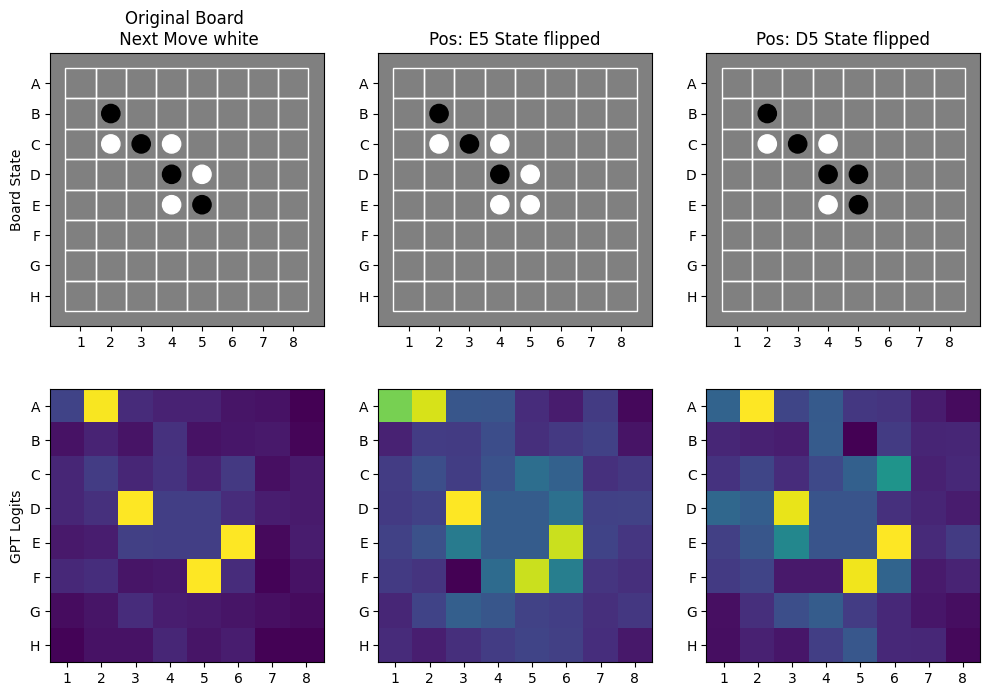

In [134]:
# Game sequence from the dataset chosen by index=#
index = 350
x, _ = game_dataset[index]
number_moves = 4
next_player = "white" if number_moves % 2 == 0 else "black"
print("Next Player: ", next_player)

intervention_moves = ["E5", "D5", ""]
probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 3
init_board, init_pred, interv_boards, interv_preds, actions = run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=True, verbose=False)

### PLot the gameboard
plot_boards = np.concatenate((init_board[None], interv_boards), axis=0)
plot_logits = np.concatenate((init_pred[None], interv_preds), axis=0)
num_plot = plot_boards.shape[0]
fig = plt.figure(figsize=(4 * num_plot, 8))
ax = plt_utils.addAxis(fig, 2, num_plot)
for i in range(num_plot):
    plt_utils.plot_game_discs(plot_boards[i], ax[i])
    ax[i + num_plot].imshow(plot_logits[i])
    ax[0].set_title(f"Original Board \n Next Move {next_player}") if i == 0 else ax[i].set_title(actions[i - 1])
plt_utils.format_ax_boardImage(ax)
ax[0].set_ylabel("Board State")
ax[num_plot].set_ylabel("GPT Logits")


## Make Latent Saliency Visualizations

In [141]:
def get_latent_saliency(x, number_moves, inspect_tile, probe_path, probe_layer, reassertion=False, verbose=False, property="New"):
    device = "cpu"
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    inspect_int = permit(inspect_tile)

    ab = OthelloBoardState()
    ab.update(tbf[:number_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)
    idx_of_interest = number_moves-1 # This corresponds to the index for the next game-move

    # Compute the intervention and the new predictions
    intervention_moves = []
    intervention_int = []
    for tile_number in range(64):
        r, c = tile_number // 8, tile_number % 8
        init_state = init_board[r,c]
        if init_state == 1.0:
            continue
        intervention_moves.append(permit_reverse(tile_number))    

    _, init_pred, _, interv_preds, _ = run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=reassertion, verbose=verbose, property=property)
    r, c = inspect_int // 8, inspect_int % 8
    init_logit = init_pred[r,c]
    interv_logit = interv_preds[:,r,c]
    grad = interv_logit - init_logit

    latent_saliency = np.empty((8,8))
    latent_saliency[:] = np.nan
    for iter, move in enumerate(intervention_moves):
        tile_number = permit(move)
        intervention_int.append(tile_number)
        r, c = tile_number // 8, tile_number % 8
        latent_saliency[r,c] = grad[iter]

    return init_board, latent_saliency, intervention_int

def sweep_latent_saliency(x, number_moves, inspect_tile_set, probe_path, probe_layer, reassertion=False, verbose=False, property="New"):
    saliency_set = []
    interv_tiles = []
    for inspect_tile in inspect_tile_set:
        init_board, latent_saliency, intervention_int = get_latent_saliency(x, number_moves, inspect_tile, probe_path, probe_layer, verbose=verbose)
        saliency_set.append(latent_saliency)
        interv_tiles.append(intervention_int)
    
    return init_board, np.stack(saliency_set), np.stack(interv_tiles)

def make_saliency_plots(init_board, saliency_set, intervention_tiles, inspect_tiles, number_moves):
    next_play = "White" if number_moves%2 == 0 else "White"

    num_sal = saliency_set.shape[0]
    fig = plt.figure(figsize=(5*(num_sal+1), 5))
    ax = plt_utils.addAxis(fig,1,num_sal+1)
    plt_utils.plot_game_discs(init_board, ax[0])
    ax[0].set_title(f"Initial Board \n Next Move: {next_play}")

    for i in range(num_sal):        
        ax[i+1].imshow(saliency_set[i,:,:])
        for tile_int in intervention_tiles[i]:
            r,c = tile_int // 8, tile_int % 8
            ax[i+1].text(c, r, round(saliency_set[i,r,c], 2), ha='center', va='center', color='w', fontsize=8)

        inspect_tile = inspect_tiles[i]
        ax[i+1].set_title(f"Inspecting {inspect_tile}")

        inspect_int = permit(inspect_tile)
        r, c = inspect_int // 8, inspect_int % 8
        square = patches.Rectangle((c-0.5, r-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
        ax[i+1].add_patch(square)

    plt_utils.format_ax_boardImage(ax)

    return

Next Player:  white


/tmp/ipykernel_994386/3375425765.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
/home/deanhazineh/Research/Emergent-World-Representations-Othello/EWOthello/utils/plot_helpers.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((j, i), 0.3, color=circle_color, edgecolor="black", fill=True)


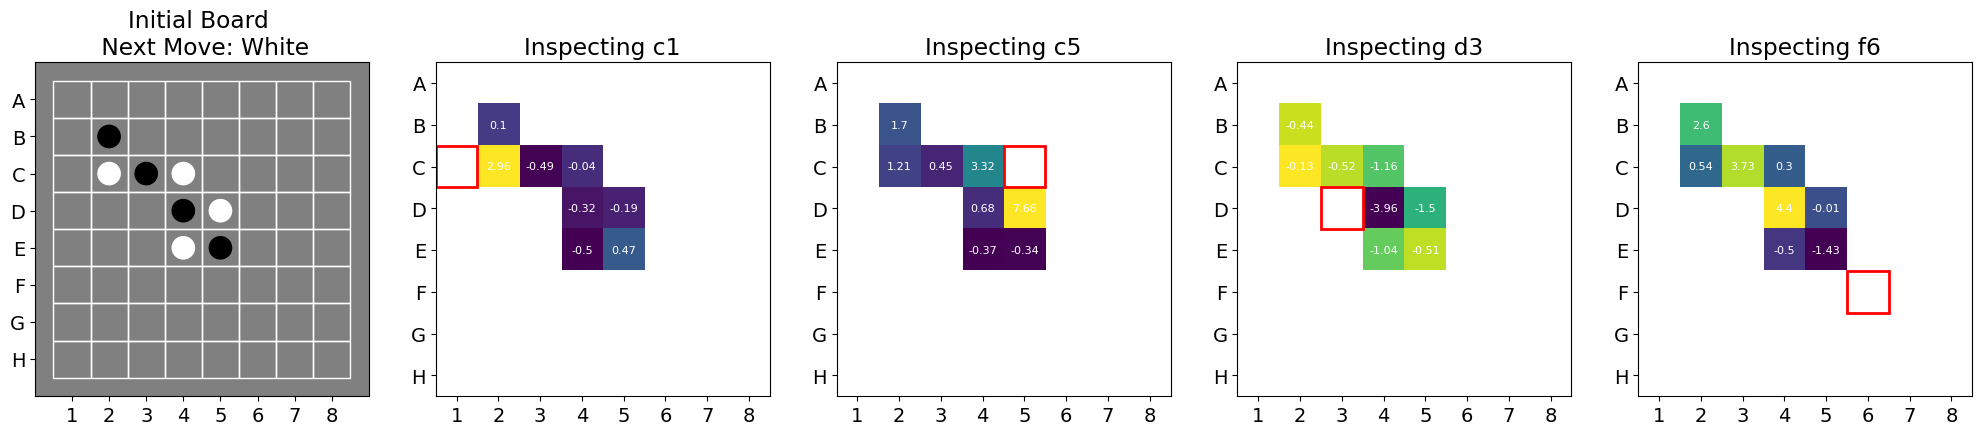

In [ ]:
plt.rcParams.update({'font.size': 14})

index = 210
x, _ = game_dataset[index]
number_moves = 4
next_player = "white" if number_moves%2==0 else "black"
print("Next Player: ", next_player)

probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 6

inspect_tiles = ["c1", "c5", "d3", "f6"]
init_board, latent_saliency, intervention_tiles_int = sweep_latent_saliency(x, number_moves, inspect_tiles, probe_path, probe_layer, verbose=False, reassertion=False)
make_saliency_plots(init_board, latent_saliency, intervention_tiles_int, inspect_tiles, number_moves)

Next Player:  white


/tmp/ipykernel_994386/3375425765.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)


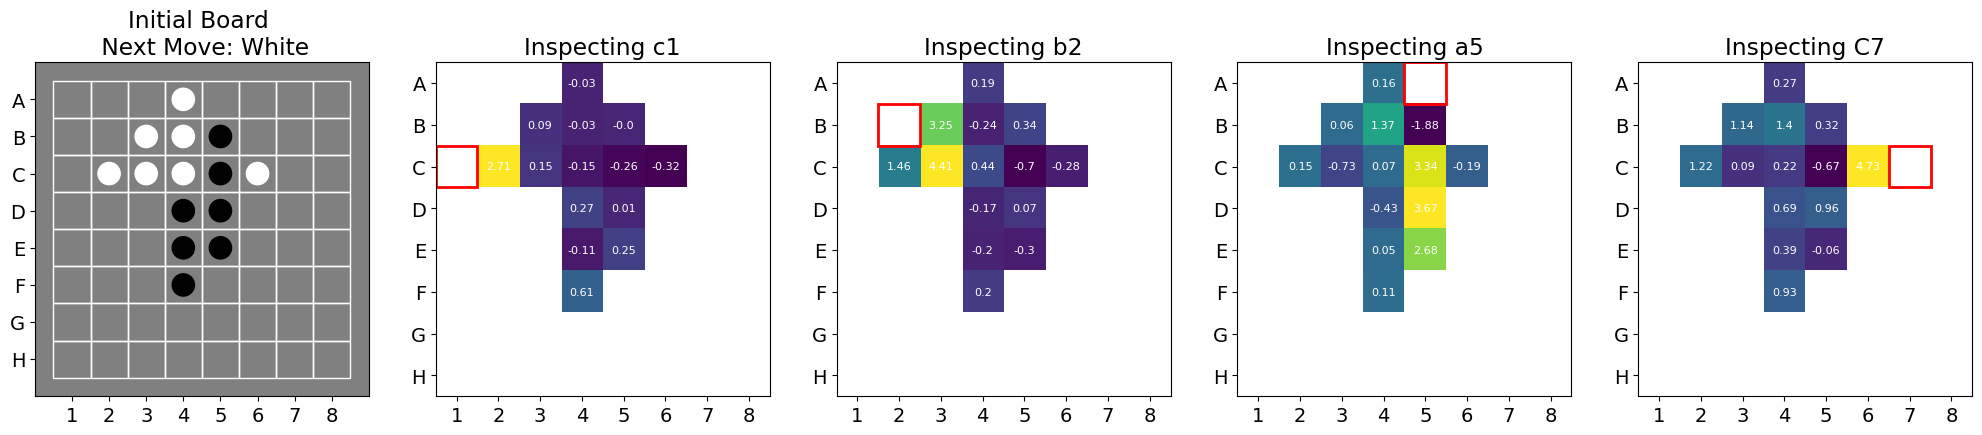

In [ ]:
plt.rcParams.update({'font.size': 14})

index = 499
x, _ = game_dataset[index]
number_moves = 10
next_player = "white" if number_moves%2==0 else "black"
print("Next Player: ", next_player)

probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 6

inspect_tiles = ["c1", "b2", "a5", "C7"]
init_board, latent_saliency, intervention_tiles_int = sweep_latent_saliency(x, number_moves, inspect_tiles, probe_path, probe_layer, verbose=False, reassertion=False)
make_saliency_plots(init_board, latent_saliency, intervention_tiles_int, inspect_tiles, number_moves)

Next Player:  white


/tmp/ipykernel_994386/3375425765.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
/home/deanhazineh/Research/Emergent-World-Representations-Othello/EWOthello/utils/plot_helpers.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((j, i), 0.3, color=circle_color, edgecolor="black", fill=True)


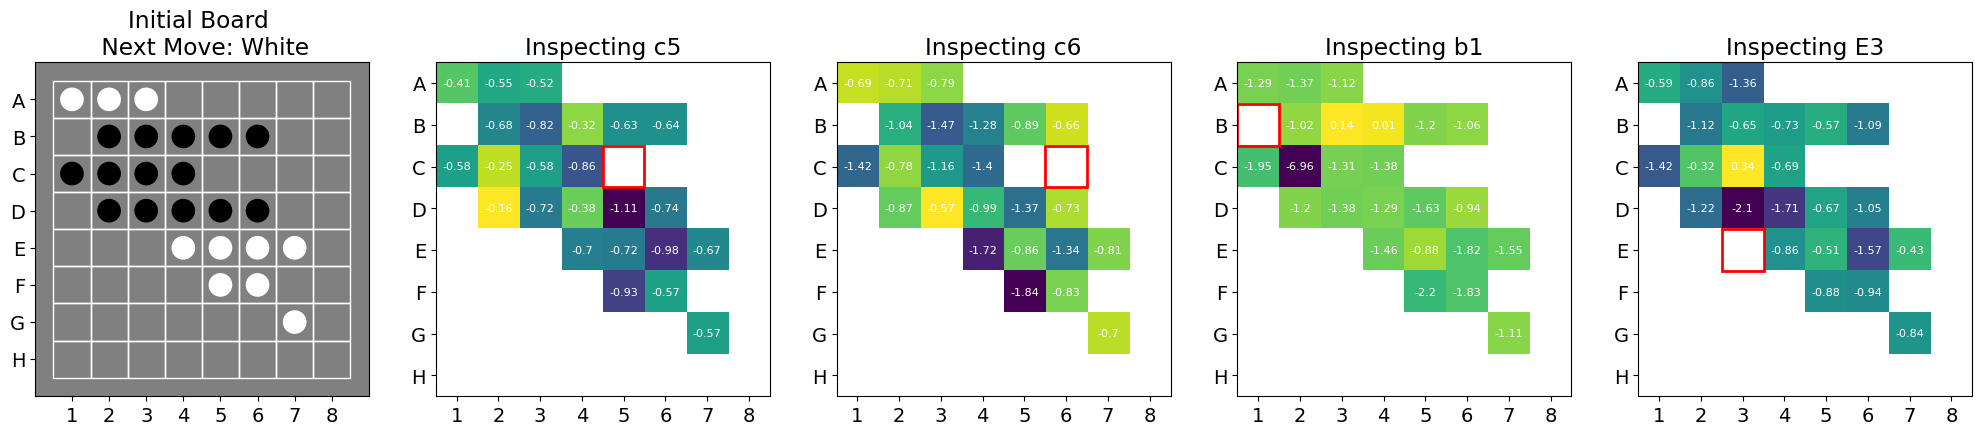

In [ ]:
index = 300
x, _ = game_dataset[index]
number_moves = 20
next_player = "white" if number_moves%2==0 else "black"
print("Next Player: ", next_player)

probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 6

inspect_tiles = ["c5", "c6", "b1", "E3"]
init_board, latent_saliency, intervention_tiles_int = sweep_latent_saliency(x, number_moves, inspect_tiles, probe_path, probe_layer, verbose=False, reassertion=False)
make_saliency_plots(init_board, latent_saliency, intervention_tiles_int, inspect_tiles, number_moves)

<!-- ## Compare the causality of the old probes -->